# LCPB 23-24 Exercise 3, XGBoost
### Group Members:
* HOOMAN SABZI 2119061
* FRANCO AQUISTAPACE TAGUA 2106651
* MARGARITA SHNAIDER 2107523
* DAIZE LI 2106187

## Import necessary modules and data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 2.0.3


In [ ]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [ ]:
!mkdir DATA

In [ ]:
file_link = 'https://docs.google.com/uc?export=download&id=' + '1G7TlJOtTMrPY920KSkIVteQFnWpB9ntC'
!wget "$file_link" -O x_XGB_24.dat

--2024-04-02 13:37:48--  https://docs.google.com/uc?export=download&id=1G7TlJOtTMrPY920KSkIVteQFnWpB9ntC
Resolving docs.google.com (docs.google.com)... 64.233.188.101, 64.233.188.139, 64.233.188.138, ...
Connecting to docs.google.com (docs.google.com)|64.233.188.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1G7TlJOtTMrPY920KSkIVteQFnWpB9ntC&export=download [following]
--2024-04-02 13:37:49--  https://drive.usercontent.google.com/download?id=1G7TlJOtTMrPY920KSkIVteQFnWpB9ntC&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.203.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116857 (114K) [application/octet-stream]
Saving to: ‘x_XGB_24.dat’

x_XGB_24.dat        100%[===================>] 114.12K  --.-KB/s    in 0

In [ ]:
!mv x_XGB_24.dat DATA

In [ ]:
file_link = 'https://docs.google.com/uc?export=download&id=' + '1aMcSXreeT-CkdoIcd_f5eyzk8-8kuEs-'
!wget "$file_link" -O y_XGB_24.dat

--2024-04-02 13:37:50--  https://docs.google.com/uc?export=download&id=1aMcSXreeT-CkdoIcd_f5eyzk8-8kuEs-
Resolving docs.google.com (docs.google.com)... 64.233.188.101, 64.233.188.139, 64.233.188.138, ...
Connecting to docs.google.com (docs.google.com)|64.233.188.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1aMcSXreeT-CkdoIcd_f5eyzk8-8kuEs-&export=download [following]
--2024-04-02 13:37:51--  https://drive.usercontent.google.com/download?id=1aMcSXreeT-CkdoIcd_f5eyzk8-8kuEs-&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.203.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8000 (7.8K) [application/octet-stream]
Saving to: ‘y_XGB_24.dat’

y_XGB_24.dat        100%[===================>]   7.81K  --.-KB/s    in 0s 

In [ ]:
!mv y_XGB_24.dat DATA

## Reference code

In [ ]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=4000, N_train=3000, L=4


[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 1
[ 24.771  46.131 -49.161 -39.356] 1
[-20.13   15.641  30.981  37.218] 1
[46.465 22.369 14.248 21.745] 1


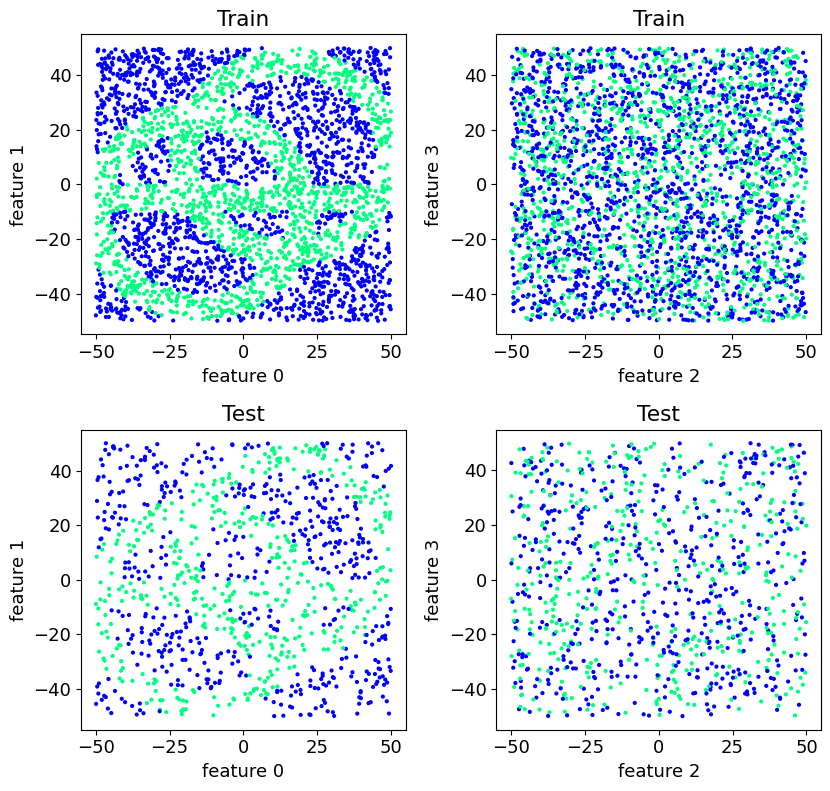

In [ ]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

In [ ]:
def classify(clf=GradientBoostingClassifier(),show=False):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   max_depth = 3 (default?)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)

    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),clf.score(x_test, y_test)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    fig,AX = plt.subplots(1,2,figsize=(8.2,4))
    scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
    scat(AX[1],x_train[:],y_train,title="training set")
    fig.tight_layout()
    plt.show()

    if show:
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)

        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)
        plt.show()

### Classify
If the “objective” hyperparameter is left unspecified, XGBClassifier looks at the data and chooses automatically the loss functions and the evaluation metrics (--> WARNING)

### XGBoost
https://xgboost.readthedocs.io/en/stable/python/python_api.html

errors: 5.20%   Accuracy=0.948


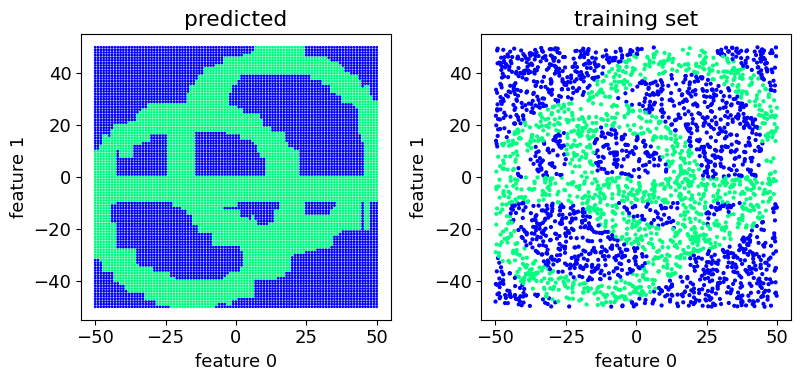

num_trees= 100


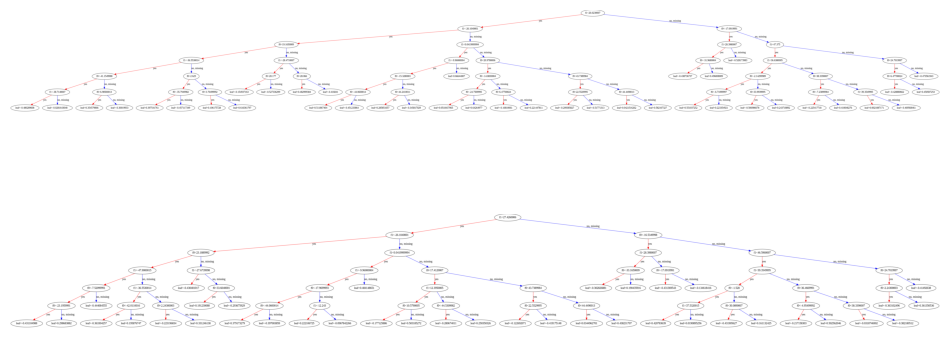

In [ ]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic')
       # importance_type="gain" #weight, cover, ...
       # learning_rate=0.4,
       # reg_lambda=0.001,
       # n_estimators=30)

classify(model, show=True)

None
[0.4891835  0.37623835 0.06590363 0.06867457]


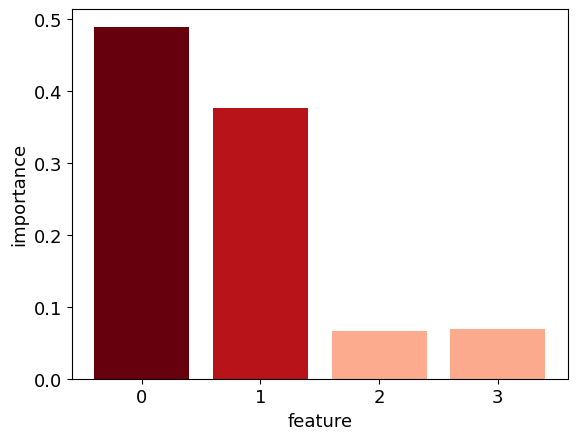

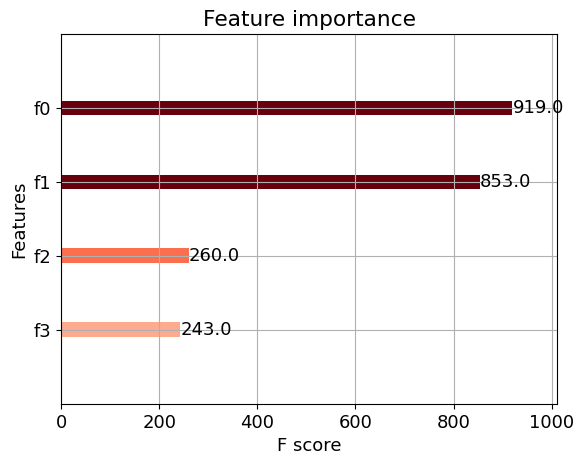

In [ ]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance

print(model.importance_type)
print(model.feature_importances_)
# plot
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_,
        color=my_cmap(rescale(model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(model,color=my_cmap(rescale_r(model.feature_importances_)))
plt.show()

Documentation: https://xgboost.readthedocs.io/en/stable/python/python_api.html

    ‘weight’: the number of times a feature is used to split the data across all trees.

    ‘gain’: the average gain across all splits the feature is used in.

    ‘cover’: the average coverage across all splits the feature is used in.

    ‘total_gain’: the total gain across all splits the feature is used in.

    ‘total_cover’: the total coverage across all splits the feature is used in.


0 weight [919. 853. 260. 243.]
1 gain [4.56883669 3.5139606  0.61552137 0.64140123]
2 total_gain [4198.76074219 2997.40844727  160.03555298  155.86050415]
3 cover [49.8643837  66.05692291 54.26316071 54.39147949]
4 total_cover [45825.3671875  56346.5546875  14108.421875   13217.12988281]


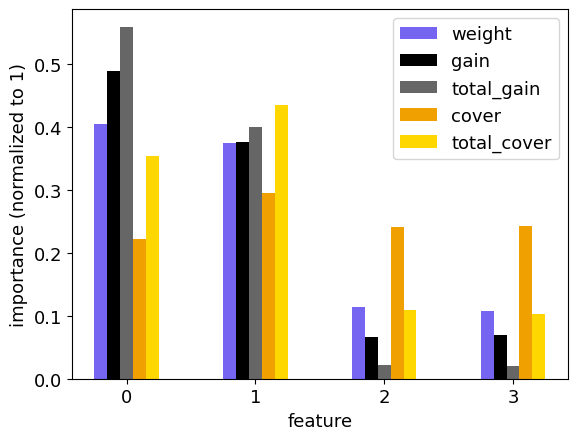

In [ ]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

### normal Gradient Boosting

errors: 19.50%   Accuracy=0.805


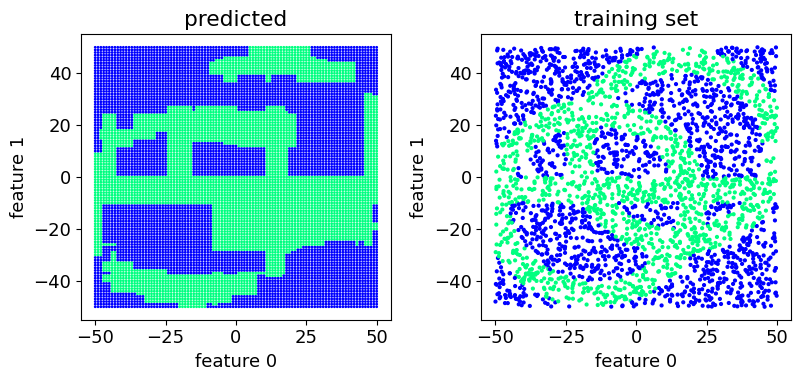

In [ ]:
# GradientBoostingClassifier()
classify()

### AdaBoost

errors: 34.10%   Accuracy=0.659


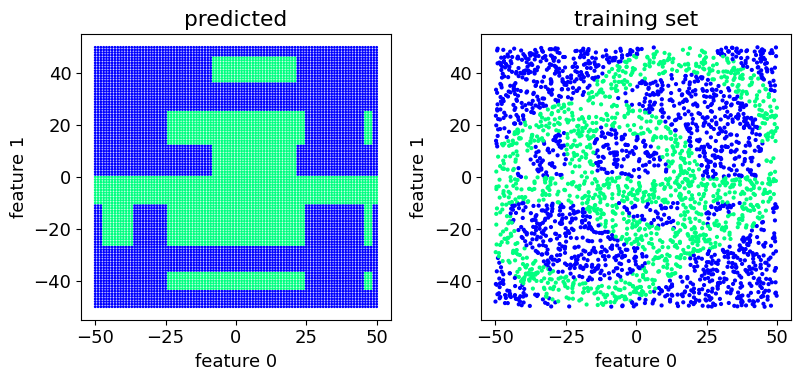

In [ ]:
classify(clf=AdaBoostClassifier())

## Exercises

### 1. Model complexity, parameters and regularization

Try different parameters (λ, γ, n_estimators, ...). Which is the simplest yet effective XGBoost model
that keeps a good validation accuracy? Is regularization useful for this analysis?

In [ ]:
param_grid = {
    'max_depth': [3,4,5],
    'learning_rate': [0, 0.1, 0.2, 0.3, 0.4],
    'gamma': [0, 0.1, 0.25, 0.5],
    'reg_lambda': [0, 0.1, 0.01, 0.001],
    'scale_pos_weight': [1, 3, 5],
    'min_child_weight': [1, 3, 5],
    'n_estimators': [30, 80, 100, 200]
}


optimal_params = RandomizedSearchCV(
    estimator = XGBClassifier(seed=1,
                      objective='binary:logistic',
                      importance_type="gain"),
    param_distributions=param_grid,
    scoring='roc_auc',
    n_iter=100,
    verbose=2,
    n_jobs=-1,
    cv=3
)

optimal_params.fit(x_train,y_train)

print(optimal_params.best_params_)
print(optimal_params.best_score_)


#output: {'scale_pos_weight': 1, 'reg_lambda': 0.01, 'n_estimators': 100,
#          'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0}
#           0.9745908834099999

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'scale_pos_weight': 1, 'reg_lambda': 0.1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.4, 'gamma': 0.1}
0.9752994714854927


errors: 6.60%   Accuracy=0.934


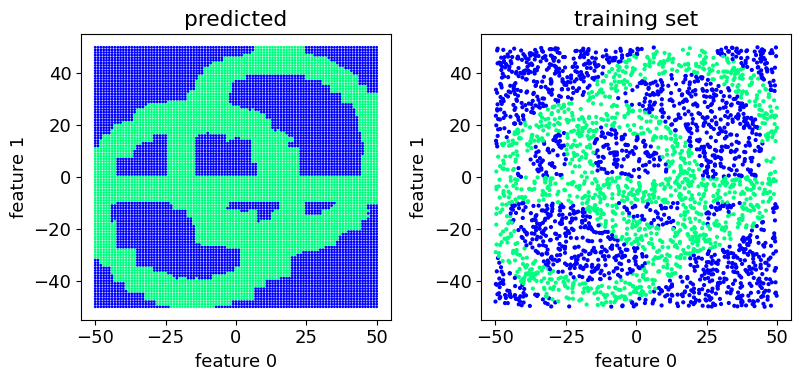

In [ ]:
model_xgb = XGBClassifier(seed=1,
                      objective='binary:logistic',
                      importance_type="gain",
          gamma=0,
          min_child_weight=1,
          learning_rate=0.2,
          max_depth=5,
          scale_pos_weight=3,
          reg_lambda=0.0,
          n_estimators=200)

classify(model_xgb)

By using a randomized search we can sample from an immense parameter space (~9000 possible configurations) and get a very good performance with a small amount of iterations. This results could be further improved by running a grid search over a reduced parameter space, centered around the optimal parameters previously determined.

### 2. Dimensionality reduction

Consider reduced data samples with L’<L features. For example, feature 0,1, and 3 out of the L=4
features.
Check if the exclusion of the least important feature(s) from training data leads to better accuracy.

In [ ]:
# Assume you want to exclude features 2 and 3
selected_features = [0, 1, 3]  # Indices of selected features

# Train XGBoost model with selected features
xgb_selected = XGBClassifier(**optimal_params.best_params_)  # Use best parameters from previous step
xgb_selected.fit(x_train[:, selected_features], y_train)

# Evaluate accuracy on validation set
accuracy_selected = xgb_selected.score(x_test[:, selected_features], y_test)
print(f"Accuracy with selected features: {accuracy_selected:.4f}")


Accuracy with selected features: 0.9520


The exclusion of the least important features does lead to an improved performance. Nevertheless, this improvement is relatively small given the fact that the algorithm was already having a very good performance.

### 3. XGBoost vs NN

Compare the validation accuracy of XGBoost with that of a simple feed-forward neural network (NN)
- By varying the number of data samples N’ in the training set (i.e., reducing the fraction N’/N of
the data set used for training)
- With cross-validation for all cases.

Is the NN or the XGB performing significantly better at low N’?

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [ ]:
def nn_vs_xgb_rf_km(N):

    # Initialize NN classifier
    nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

    # Train NN on N'
    nn_model.fit(x_train[:N], y_train[:N])

    # Evaluate NN accuracy
    accuracy_nn = nn_model.score(x_test, y_test)
    #print(f"NN accuracy: {accuracy_nn:.4f}")

    model_xgb = XGBClassifier(seed=1,
                      objective='binary:logistic',
                      importance_type="gain",
          gamma=0,
          min_child_weight=1,
          learning_rate=0.2,
          max_depth=5,
          scale_pos_weight=3,
          reg_lambda=0.0,
          n_estimators=200)

    model_xgb.fit(x_train[:N],y_train[:N])

    accuracy_xgb = model_xgb.score(x_test, y_test)
    #print(f"XGBoost accuracy: {accuracy_xgb:.4f}")

    # Initialize Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(x_train[:N], y_train[:N])
    accuracy_rf = rf_model.score(x_test, y_test)

    # Initialize KMeans clustering
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(x_train[:N])
    kmeans_labels_train = kmeans.labels_
    kmeans_labels_test = kmeans.predict(x_test)
    accuracy_km = accuracy_score(y_test, kmeans_labels_test)

    return accuracy_nn, accuracy_xgb, accuracy_rf, accuracy_km

In [ ]:

N_ = np.arange(int(0.3*N_train), int(N_train), 200)
acc_nn, acc_xgb, acc_rf, acc_km = list(), list(), list(), list()

for i in N_:
  acc_tmp = nn_vs_xgb_rf_km(i)
  acc_nn.append(acc_tmp[0])
  acc_xgb.append(acc_tmp[1])
  acc_rf.append(acc_tmp[2])
  acc_km.append(acc_tmp[3])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

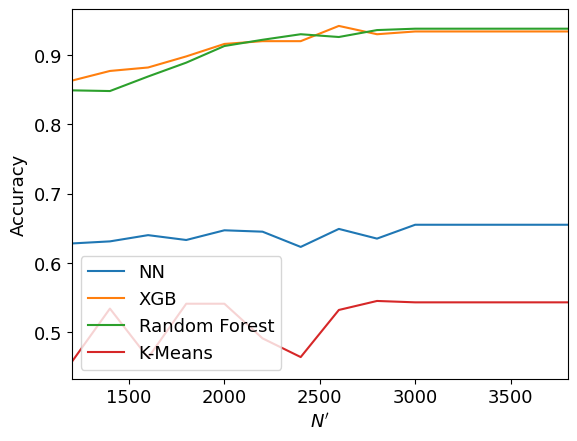

In [ ]:
plt.plot(N_, acc_nn, label='NN')
plt.plot(N_, acc_xgb, label='XGB')
plt.plot(N_, acc_rf, label='Random Forest')
plt.plot(N_, acc_km, label='K-Means')
plt.xlim(left=min(N_), right=max(N_));
plt.ylabel("Accuracy")
plt.xlabel(r"$N^\prime$")
plt.legend();

Overall, XGBoost substantially outperforms the MLPClassifier algorithm. Additionally, we see that XGBoost gets a very reasonable accuracy with a very reduced amount of data.

## Some more effort on the NNs...

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
print('TF version:', tf.__version__)

TF version: 2.15.0


In [ ]:
def gen_model(layers, lr=0.001):
    nn_model = tf.keras.models.Sequential(layers=layers)
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])
    return nn_model

In [ ]:
activation1 = 'selu'
layers1 = [Input(shape=(4,)),
          Dense(1000, activation=activation1),
          Dense(500, activation=activation1),
          Dropout(0.1),
          Dense(200, activation=activation1),
          Dropout(0.1),
          Dense(100, activation=activation1),
          Dense(50, activation=activation1),
          Dense(10, activation=activation1),
          Dense(1, activation='sigmoid')]
model1 = gen_model(layers1, lr=1e-4)

In [ ]:
history1 = model1.fit(x=x_train, y=y_train, batch_size=32,
                      validation_data=[x_test, y_test],
                      epochs=5)

Epoch 1/5
94/94 [==============================] - 4s 20ms/step - loss: 0.9528 - accuracy: 0.5417 - val_loss: 0.7290 - val_accuracy: 0.6100
Epoch 2/5
94/94 [==============================] - 1s 14ms/step - loss: 0.7254 - accuracy: 0.6080 - val_loss: 0.6727 - val_accuracy: 0.6080
Epoch 3/5
94/94 [==============================] - 1s 13ms/step - loss: 0.6786 - accuracy: 0.6177 - val_loss: 0.6403 - val_accuracy: 0.6570
Epoch 4/5
94/94 [==============================] - 1s 14ms/step - loss: 0.6617 - accuracy: 0.6320 - val_loss: 0.6380 - val_accuracy: 0.6420
Epoch 5/5
94/94 [==============================] - 2s 21ms/step - loss: 0.6476 - accuracy: 0.6367 - val_loss: 0.6265 - val_accuracy: 0.6440


A very small improvement is achieved with an unnecessarily big network (computationally expensive), over the MLPClassifier. Therefore, XGBoost is the preferred algorithm in this scenario.

## What happens if we use dimensionality reduction on the NN?

In [ ]:
activation2 = 'selu'
layers2 = [Input(shape=(2,)),
          Dense(1000, activation=activation2),
          Dense(500, activation=activation2),
          Dropout(0.1),
          Dense(200, activation=activation2),
          Dropout(0.1),
          Dense(100, activation=activation2),
          Dense(50, activation=activation2),
          Dense(10, activation=activation2),
          Dense(1, activation='sigmoid')]
model2 = gen_model(layers2, lr=1e-3)

In [ ]:
history2 = model2.fit(x=x_train[:, [0,1]], y=y_train,
                      batch_size=32,
                      validation_data=[x_test[:, [0,1]], y_test],
                      epochs=5)

Epoch 1/5
94/94 [==============================] - 9s 39ms/step - loss: 1.0090 - accuracy: 0.5847 - val_loss: 0.6762 - val_accuracy: 0.6520
Epoch 2/5
94/94 [==============================] - 3s 31ms/step - loss: 0.6647 - accuracy: 0.6320 - val_loss: 0.6460 - val_accuracy: 0.6760
Epoch 3/5
94/94 [==============================] - 3s 37ms/step - loss: 0.6629 - accuracy: 0.6453 - val_loss: 0.5744 - val_accuracy: 0.6690
Epoch 4/5
94/94 [==============================] - 3s 35ms/step - loss: 0.6114 - accuracy: 0.6650 - val_loss: 0.5669 - val_accuracy: 0.6400
Epoch 5/5
94/94 [==============================] - 5s 49ms/step - loss: 0.5965 - accuracy: 0.6787 - val_loss: 0.5660 - val_accuracy: 0.6870


Still performs extremely poorly when compared to XGBoost.

In [ ]:
activation3 = 'relu'
layers3 = [Input(shape=(2,)),
          Dense(5000, activation=activation3),
          Dense(1000, activation=activation3),
          Dense(10, activation=activation3),
          Dense(1, activation='sigmoid')]
model3 = gen_model(layers3)

In [ ]:
history3 = model3.fit(x=x_train[:, [0,1]], y=y_train,
                      batch_size=32,
                      validation_data=[x_test[:, [0,1]], y_test],
                      epochs=5)

Epoch 1/5
94/94 [==============================] - 26s 246ms/step - loss: 0.6865 - accuracy: 0.5467 - val_loss: 0.6685 - val_accuracy: 0.5500
Epoch 2/5
94/94 [==============================] - 15s 159ms/step - loss: 0.6525 - accuracy: 0.5727 - val_loss: 0.6557 - val_accuracy: 0.5870
Epoch 3/5
94/94 [==============================] - 8s 86ms/step - loss: 0.6435 - accuracy: 0.5900 - val_loss: 0.6569 - val_accuracy: 0.5300
Epoch 4/5
94/94 [==============================] - 9s 97ms/step - loss: 0.6473 - accuracy: 0.5523 - val_loss: 0.6558 - val_accuracy: 0.5430
Epoch 5/5
94/94 [==============================] - 9s 96ms/step - loss: 0.6484 - accuracy: 0.5507 - val_loss: 0.6492 - val_accuracy: 0.5460


# Paper assignment

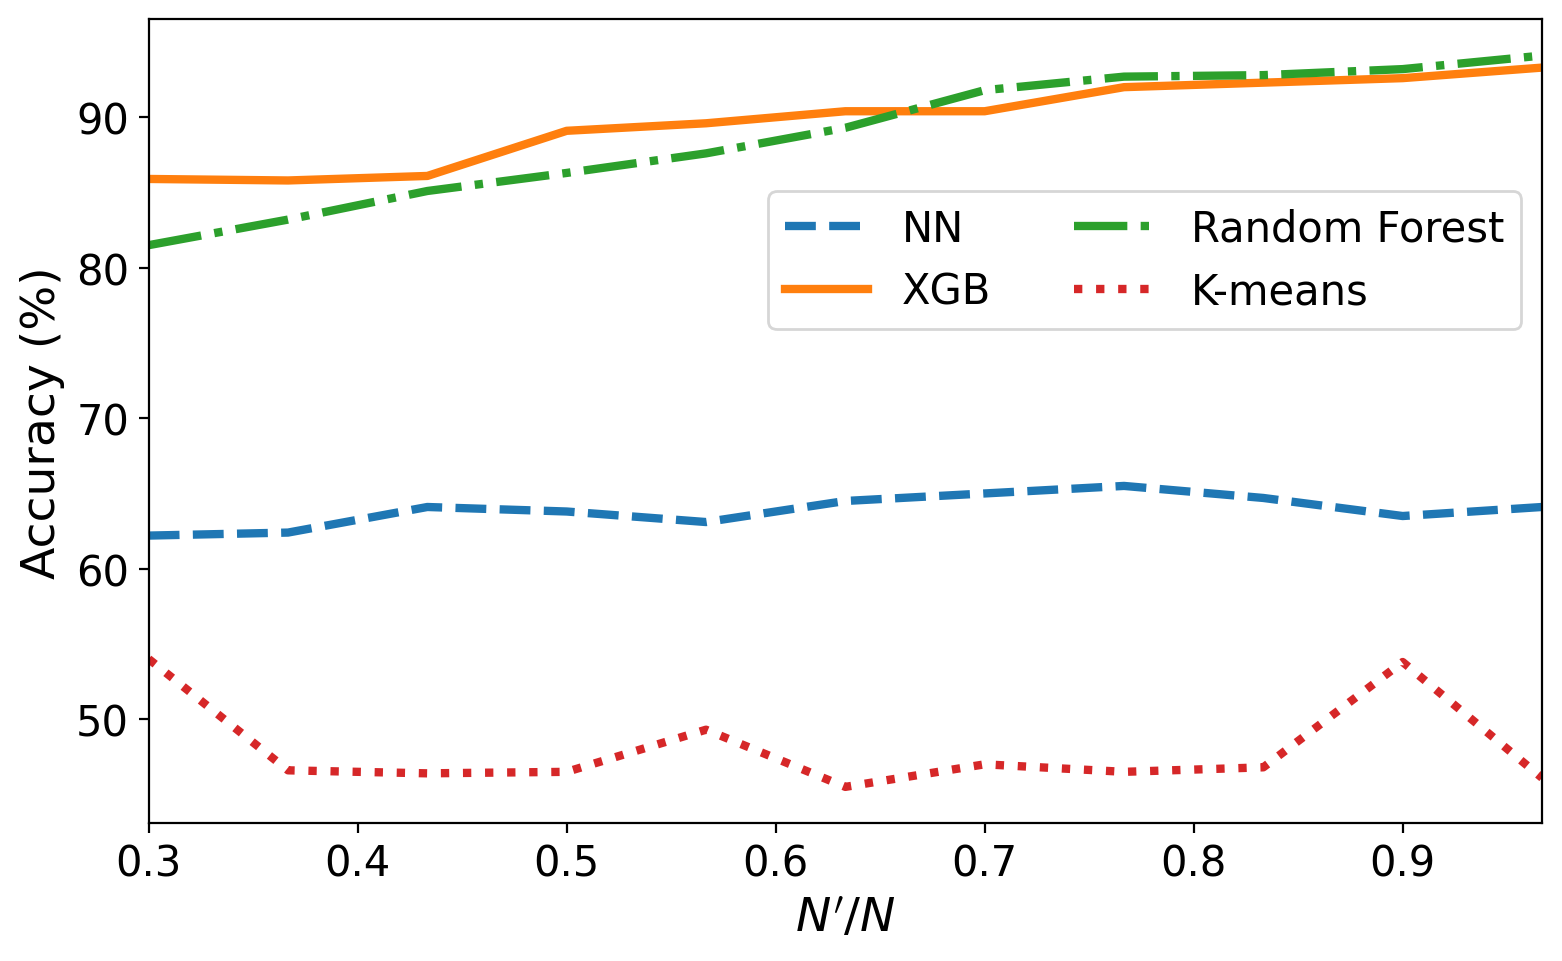

In [ ]:
# Some additional plots for the paper assignment
FONTSIZE=17
fig, ax = plt.subplots(figsize=(8,5), ncols=1, nrows=1, dpi=200)
plt.plot(np.array(N_)/N_train, 100*np.array(acc_nn), '--', label='NN', lw=3)
plt.plot(np.array(N_)/N_train, 100*np.array(acc_xgb), label='XGB', lw=3)
plt.plot(np.array(N_)/N_train, 100*np.array(acc_rf), '-.', label='Random Forest', lw=3)
plt.plot(np.array(N_)/N_train, 100*np.array(acc_km), ':', label='K-means', lw=3)
plt.xlim(left=min(N_)/N_train, right=max(N_)/N_train)
plt.tick_params(labelsize=FONTSIZE-2)
plt.ylabel("Accuracy (%)", fontsize=FONTSIZE)
plt.xlabel(r"$N^\prime / N$", fontsize=FONTSIZE)
plt.legend(fontsize=FONTSIZE-2, ncol=2, loc='right',
           bbox_to_anchor=(1.,0.7))
plt.tight_layout()
plt.savefig('XGBoost_vs_NN_vs_RF_KM_accuracy.png', dpi=200);

In [ ]:
def nn_vs_xgb_selected(N):
    selected_features = [0, 1, 3]  # Indices of selected features

    # Initialize NN classifier
    nn_model = MLPClassifier(hidden_layer_sizes=(100,),
                             max_iter=1000, random_state=42)

    # Train NN on N'
    nn_model.fit(x_train[:N, selected_features], y_train[:N])

    # Evaluate NN accuracy
    accuracy_nn = nn_model.score(x_test[:, selected_features],
                                 y_test)
    #print(f"NN accuracy: {accuracy_nn:.4f}")

    model_xgb = XGBClassifier(seed=1,
                      objective='binary:logistic',
                      importance_type="gain",
          gamma=0,
          min_child_weight=1,
          learning_rate=0.2,
          max_depth=5,
          scale_pos_weight=3,
          reg_lambda=0.0,
          n_estimators=200)

    model_xgb.fit(x_train[:N, selected_features],y_train[:N])

    accuracy_xgb = model_xgb.score(x_test[:, selected_features], y_test)
    #print(f"XGBoost accuracy: {accuracy_xgb:.4f}")

    # Initialize Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(x_train[:N, selected_features], y_train[:N])
    accuracy_rf = rf_model.score(x_test[:, selected_features], y_test)

    # Initialize KMeans clustering
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(x_train[:N, selected_features])
    kmeans_labels_train = kmeans.labels_
    kmeans_labels_test = kmeans.predict(x_test[:, selected_features])
    accuracy_km = accuracy_score(y_test, kmeans_labels_test)

    return accuracy_nn, accuracy_xgb, accuracy_rf, accuracy_km

In [ ]:
N_ = np.arange(int(0.3*N_train), int(N_train), 200)
acc_nn_selected, acc_xgb_selected, acc_rf_selected, acc_km_selected = list(), list(), list(), list()

for i in N_:
  acc_tmp_selected = nn_vs_xgb_selected(i)
  acc_nn_selected.append(acc_tmp_selected[0])
  acc_xgb_selected.append(acc_tmp_selected[1])
  acc_rf_selected.append(acc_tmp_selected[2])
  acc_km_selected.append(acc_tmp_selected[3])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

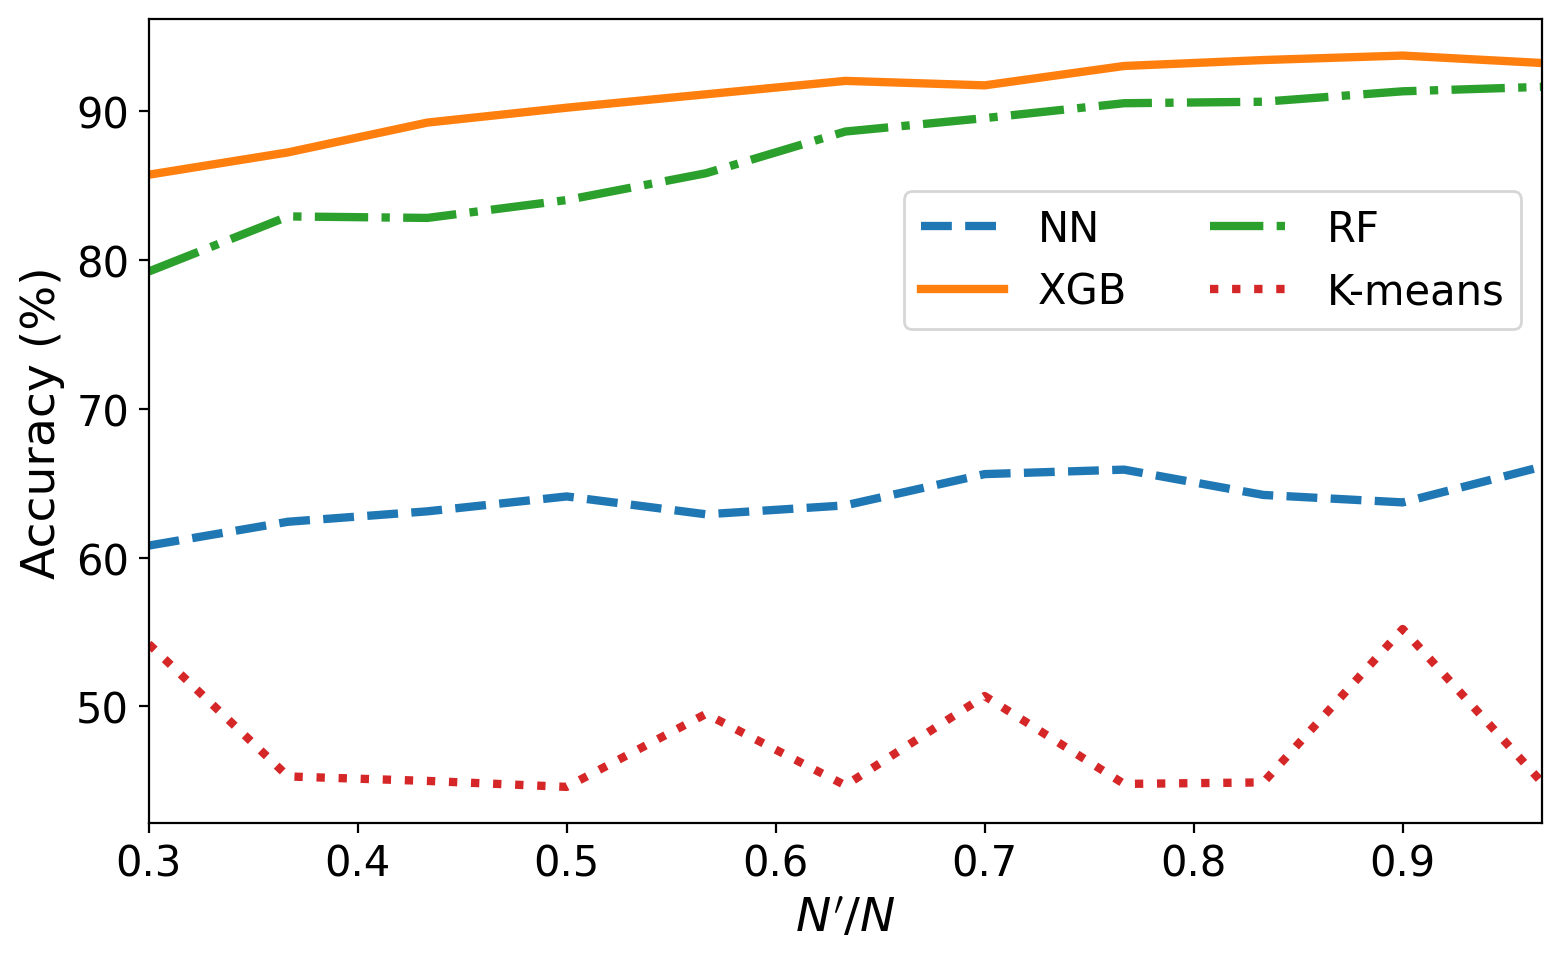

In [ ]:
# Some additional plots for the paper assignment
FONTSIZE=17
fig, ax = plt.subplots(figsize=(8,5), ncols=1, nrows=1, dpi=200)
plt.plot(np.array(N_)/N_train, 100*np.array(acc_nn_selected), '--', label='NN', lw=3)
plt.plot(np.array(N_)/N_train, 100*np.array(acc_xgb_selected), label='XGB', lw=3)
plt.plot(np.array(N_)/N_train, 100*np.array(acc_rf_selected), '-.', label='RF', lw=3)
plt.plot(np.array(N_)/N_train, 100*np.array(acc_km_selected), ':', label='K-means', lw=3)
plt.xlim(left=min(N_)/N_train, right=max(N_)/N_train)
plt.tick_params(labelsize=FONTSIZE-2)
plt.ylabel("Accuracy (%)", fontsize=FONTSIZE)
plt.xlabel(r"$N^\prime / N$", fontsize=FONTSIZE)
plt.legend(fontsize=FONTSIZE-2, ncol=2, loc='right',
           bbox_to_anchor=(1.,0.7))
plt.tight_layout()
plt.savefig('XGBoost_vs_NN_accuracy_selected_features.png', dpi=200);

In [ ]:
# Classification from best XGBoost
pad = 1
x_vals = np.linspace(x_train[:,0].min()-pad, x_train[:,0].max()+pad,
                     200)
y_vals = np.linspace(x_train[:,1].min()-pad, x_train[:,1].max()+pad,
                     200)
grid_vals = np.array([[i, j, 0, 0] for i in x_vals for j in y_vals])

# Define model
model_xgb = XGBClassifier(seed=1,
                      objective='binary:logistic',
                      importance_type="gain",
                      gamma=0,
                      min_child_weight=1,
                      learning_rate=0.2,
                      max_depth=5,
                      scale_pos_weight=3,
                      reg_lambda=0.0,
                      n_estimators=200)
# Train and predict
model_xgb.fit(x_train, y_train)
preds = model_xgb.predict(grid_vals)

In [ ]:
# Reshape preds as grid and transform
preds_grid = np.reshape(preds, (200, 200))
preds_grid_rot = np.flip(np.swapaxes(preds_grid, 0, 1).copy(), 0)

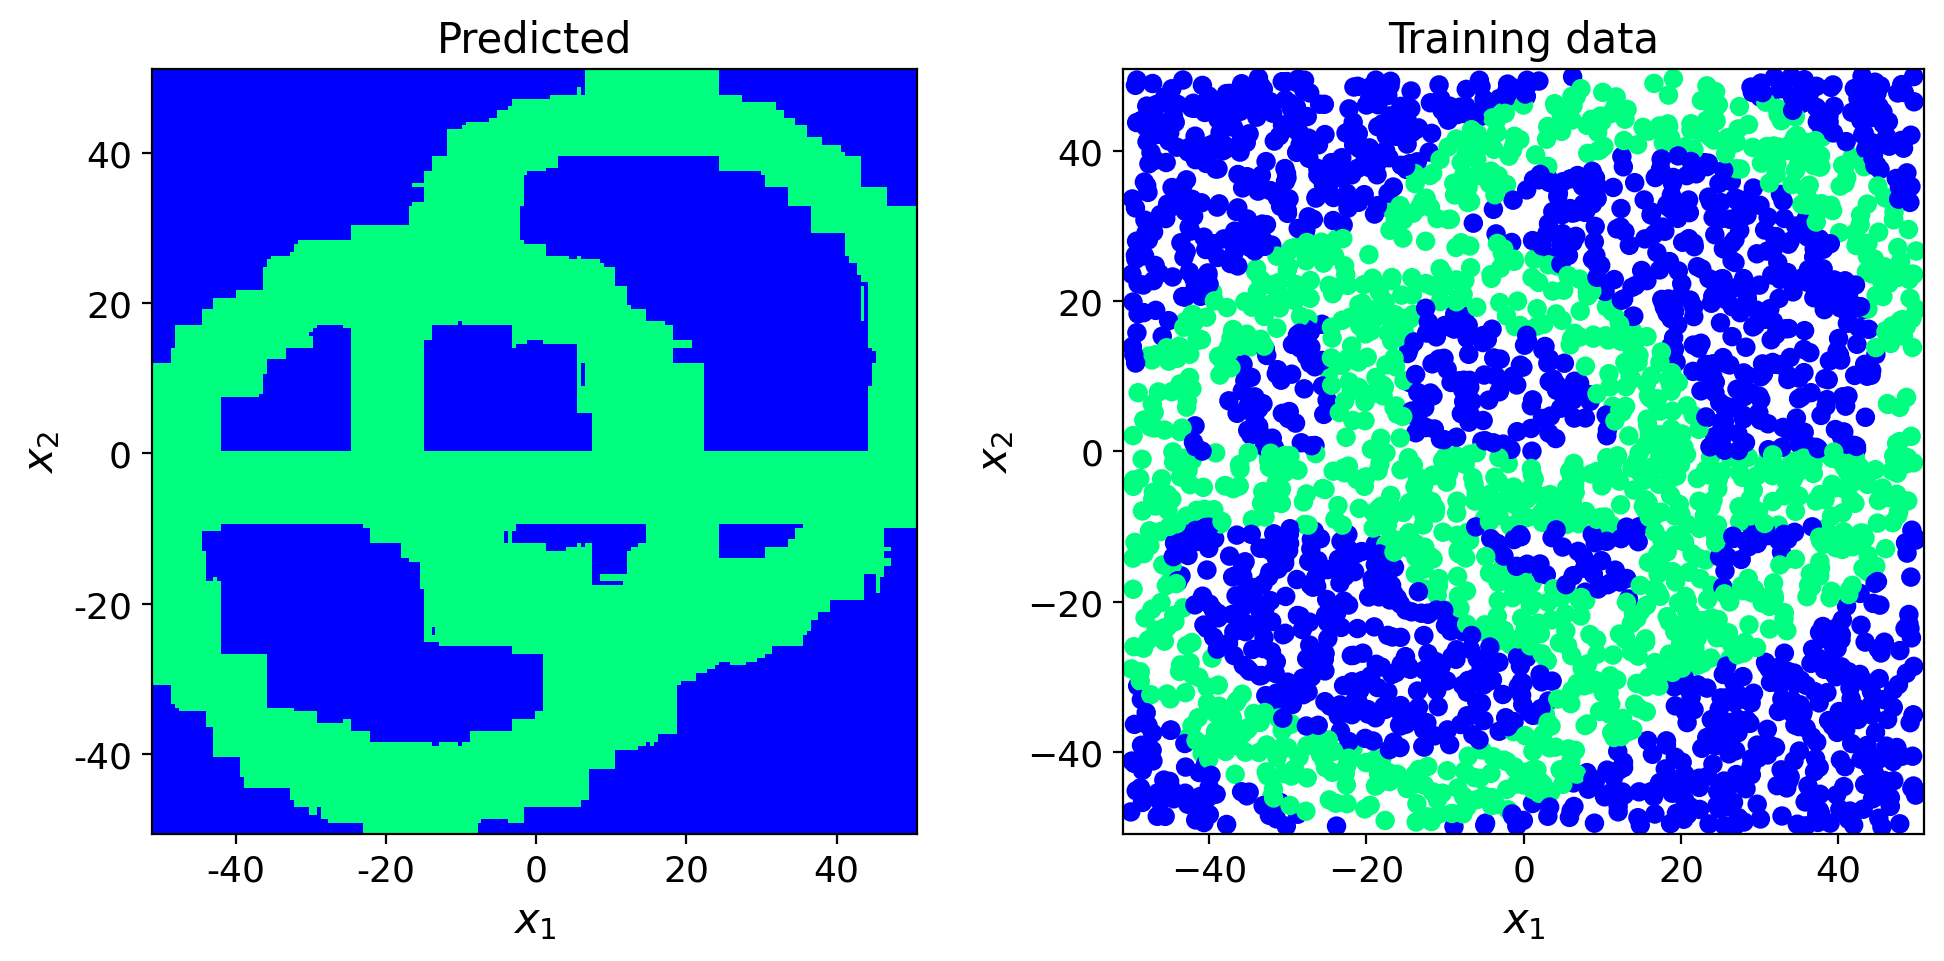

In [ ]:
# Plot results
FONTSIZE = 15
fig, (ax1, ax2) = plt.subplots(figsize=(10,5), dpi=200, nrows=1, ncols=2)

# Predictions
ax1.imshow(preds_grid_rot)
ax1.set_xlabel(r'$x_1$', fontsize=FONTSIZE)
ax1.set_ylabel(r'$x_2$', fontsize=FONTSIZE)
ax1.tick_params(labelsize=FONTSIZE-2)
# Get correct labels
num_plot_vals = [-40, -20, 0, 20, 40]
x_delta = x_train[:,0].max() - x_train[:,0].min() + 2*pad
x_plot_pos = [200 * (x_train[:,0].max() + pad + n) / x_delta for n in num_plot_vals]
ax1.set_xticks(x_plot_pos)
ax1.set_xticklabels(num_plot_vals)

y_delta = x_train[:,1].max() - x_train[:,1].min() + 2*pad
y_plot_pos = [200 * (x_train[:,1].max() + pad - n) / x_delta for n in num_plot_vals]
ax1.set_yticks(y_plot_pos)
ax1.set_yticklabels(num_plot_vals)
ax1.set_title('Predicted', fontsize=FONTSIZE)

# Training data
ax2.scatter(x_train[:,0], x_train[:,1], c=y_train)
ax2.set_xlabel(r'$x_1$', fontsize=FONTSIZE)
ax2.set_ylabel(r'$x_2$', fontsize=FONTSIZE)
ax2.tick_params(labelsize=FONTSIZE-2)
ax2.set_xlim(left=x_train[:,0].min()-pad,
             right=x_train[:,0].max()+pad)
ax2.set_ylim(bottom=x_train[:,1].min()-pad,
             top=x_train[:,1].max()+pad)
ax2.set_title('Training data', fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig('XGBoost_best_predictions_and_training.png', dpi=200);

## Quantifying the effect of cross-fold validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [ ]:
# Make scorer
acc_scorer = make_scorer(accuracy_score)
# Test different value for cv
cv_vals = [2, 3, 5, 7, 10]
results = []
for cv in cv_vals:
    # Build model
    model_xgb = XGBClassifier(seed=1,
                      objective='binary:logistic',
                      importance_type="gain",
                      gamma=0,
                      min_child_weight=1,
                      learning_rate=0.2,
                      max_depth=5,
                      scale_pos_weight=3,
                      reg_lambda=0.0,
                      n_estimators=200)
    cv_res = cross_val_score(model_xgb, x_train, y_train,
                             scoring=acc_scorer, cv=cv)
    results.append(cv_res)

In [ ]:
res_means = []
res_stds = []
for r in results:
    res_means.append(np.mean(r))
    res_stds.append(np.std(r))

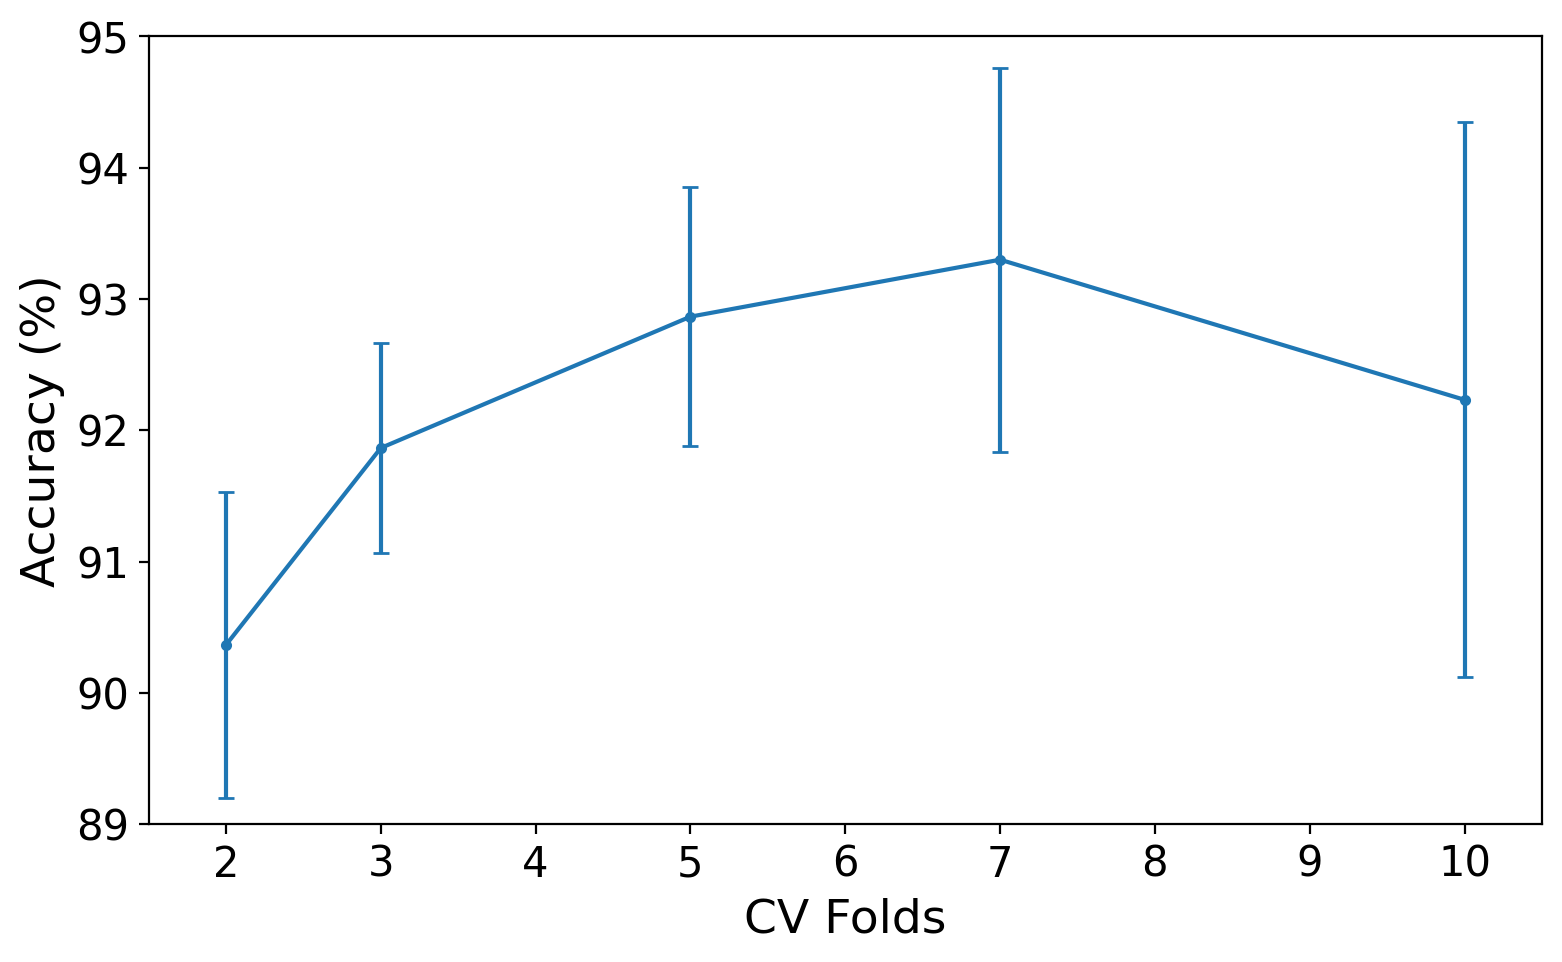

In [ ]:
FONTSIZE=17
fig, ax = plt.subplots(figsize=(8,5), ncols=1, nrows=1, dpi=200)
plt.errorbar(cv_vals, res_means, yerr=res_stds, capsize=3,
             linestyle='-', marker='.')
plt.xlim(left=1.5, right=10.5)
plt.ylim(top=0.95, bottom=0.89)
y_tick_vals = 89 + np.arange(7)
plt.yticks(y_tick_vals/100, y_tick_vals)
plt.tick_params(labelsize=FONTSIZE-2)
plt.ylabel("Accuracy (%)", fontsize=FONTSIZE)
plt.xlabel(r"CV Folds", fontsize=FONTSIZE)
#plt.legend(fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig('acc_vs_cvfolds_XGBoost.png', dpi=200);